In [1]:
import glob
import xarray as xr
import numpy as np
from datetime import datetime,timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
data_direc = '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/'
hls_outputs = data_direc+'HLS_data/'
# modis_direc = '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/MODIS/'
selected_domain = '07'
selected_trial = '33'
selected_wy = 2023
version = 'S30'
# version = 'L30'

out_direcc = '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_processed/'
domains_direc = '/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/ASO/selected/'
# in distance (m) from edge of the reference raster
buffer = 50

In [66]:
dom_ref = domains_direc+'domain'+str(selected_domain).zfill(2)+'_trial'+str(selected_trial).zfill(2)+'.tif'
dom_ref = xr.open_dataset(dom_ref).isel(band=0).rio.reproject(4326)

def read_txtfile(filename):
    with open(filename,'r') as file:
        lines = [line.strip() for line in file]
    return lines
focus_tile = read_txtfile(data_direc+'all_tiles.txt')[0]
print(focus_tile)

13SCB


In [67]:
# Function to find the index
def find_index(A, B, C, D):
    for i in range(len(A)):
        if A[i] == C and B[i] == D:
            return i
    return None  # Return None if no match is found

def good_vals():
    good_vals = []
    # aerosol (00 = climatology,01 = low,10 = average,11 = high)
    for bin76 in ['00','01','10','11']:
        # water
        for bin5 in ['0']:
            # snow/ice
            for bin4 in ['0','1']:
                # cloud shadow
                for bin3 in ['0']:
                    # adjacent to cloud
                    for bin2 in ['0','1']:
#                     for bin2 in ['0']:
                        # cloud
                        for bin1 in ['0']:
                            # cirrus cloud
                            for bin0 in ['0']:
                                good_vals.append(int(bin76+bin5+bin4+bin3+bin2+bin1+bin0,2))
    return good_vals

good_vals = good_vals()
print(good_vals)

[0, 4, 16, 20, 64, 68, 80, 84, 128, 132, 144, 148, 192, 196, 208, 212]


In [73]:
date_array = []
files_array = []

# loop through the year before and after the selected water years 
for yrCount,year in enumerate([selected_wy-1,selected_wy]):
    print(year,version)
    # detemrine the hls files with the specified verion, year, and tile
    HLS_files = sorted(glob.glob(hls_outputs+version+'/'+str(year)+'/'+focus_tile+'/HLS.*.v2.0'))
    # pull the date (days from Jan 1?) from the HLS filename
    dates = np.array([int(file.split('/')[-1].split('.')[3][4:7]) for file in HLS_files])

    # determine the date corresponding to the start of the WY (from 1 Sep)
    dayDiff = (datetime(year,9,1)-datetime(year,1,1)).days
    # pulling data from the year before and the water year, filter to only include the water year
    if yrCount == 0:
        mask = dates >= dayDiff
    else:
        mask = dates < dayDiff

    # concatenate the good files and dates
    files_array.extend([HLS_files[i] for i in range(len(HLS_files)) if mask[i]])
    dates = dates[mask]
    date_array.extend([datetime(year-1,12,31)+timedelta(days=int(dys)) for dys in dates])
 
date_array = pd.to_datetime(date_array)
print(len(files_array))
print(date_array)
# print(files_array[0])

2022 S30
2023 S30
127
DatetimeIndex(['2022-08-31', '2022-09-03', '2022-09-08', '2022-09-10',
               '2022-09-13', '2022-09-15', '2022-09-18', '2022-09-20',
               '2022-09-23', '2022-09-25',
               ...
               '2023-08-04', '2023-08-06', '2023-08-09', '2023-08-11',
               '2023-08-14', '2023-08-16', '2023-08-19', '2023-08-24',
               '2023-08-26', '2023-08-29'],
              dtype='datetime64[ns]', length=127, freq=None)


In [74]:
da = xr.Dataset()

# loop through the files selected by the previous cell
for subCount,subb in enumerate(files_array):
    print(subb)
    # determine the mask based on the "good_vals" from above
    mask = glob.glob(subb+'/*Fmask.tif')[0]
#     mask = xr.open_rasterio(mask).isel(band=0).to_dataset(name='mask')
    mask = xr.open_dataset(mask).isel(band=0)#.to_dataset(name='mask')
    mask = mask.rename({'band_data':'mask'})
    condition = np.isin(mask['mask'], good_vals)
    condition = xr.Dataset({'condition': (('y', 'x'),condition)})
    mask['condition'] = condition['condition']
    mask['mask'] = mask['mask'].where(mask['condition'], -1, 0)
        
    # load green band (identical for S and L data)
    green = glob.glob(subb+'/*B03.tif')[0]
#     green = xr.open_rasterio(green)[0,:,:]
    green = xr.open_dataset(green).isel(band=0)#[0,:,:]
    
    # WHY IS THIS ONLY FOR THE FIRST LOOP THROUGH??
    if subCount == 0:
#         reproject the MODIS reference data to the HLS CRS
#         modis = modis.rio.reproject(green.rio.crs)
#         modis_x = modis.x.values
#         modis_y = modis.y.values
#         # determine filter extents? Must be in UTM??
#         min_x = np.min(modis_x)-500.0
#         min_y = np.min(modis_y)-500.0
#         max_x = np.max(modis_x)+500.0
#         max_y = np.max(modis_y)+500.0
        reff = dom_ref.rio.reproject(green.rio.crs)
        min_x = np.min(reff.x.values)-buffer
        min_y = np.min(reff.y.values)-buffer
        max_x = np.max(reff.x.values)+buffer
        max_y = np.max(reff.y.values)+buffer
        
        # filter the green to the new bounds??
        # aren't these new bounds larger than the initial green??
        green = green.sel(x=slice(min_x,max_x),y=slice(max_y,min_y))

        # initialize the xr dataset
        da.coords['time'] = date_array
        da.coords['y'] = green.y
        da.coords['x'] = green.x
          
        # prep the data to be filled later in the loop
        # NDSI
        holder1 = np.empty((len(date_array),len(green.y),len(green.x)))
        holder1[:] = np.nan
        holder1 = xr.DataArray(holder1, dims=('time', 'y', 'x'))
        da['NDSI'] = holder1    
        # Mask
        holder2 = np.empty((len(date_array),len(green.y),len(green.x)))
        holder2[:] = 0
        holder2 = xr.DataArray(holder2, dims=('time', 'y', 'x'))
        da['Mask'] = holder2
     
    # read in the SWIR data
    # if sentinel
    if version == 'S30':
        swir = glob.glob(subb+'/*B11.tif')[0]
    # if landsat
    else:
        swir = glob.glob(subb+'/*B06.tif')[0] 
#     swir = xr.open_rasterio(swir)[0,:,:]
    swir = xr.open_dataset(swir).isel(band=0)
    
    # filter to common grid
    green = green.sel(x=slice(min_x,max_x),y=slice(max_y,min_y))
    swir = swir.sel(x=slice(min_x,max_x),y=slice(max_y,min_y))
    mask = mask.sel(x=slice(min_x,max_x),y=slice(max_y,min_y))
    mask['green'] = green['band_data']
    mask['mask'] = xr.where(mask['green']==-9999,0,mask['mask'])

    # calculate the NDSI
    da['NDSI'][subCount,:,:] = ((green['band_data']-swir['band_data'])/(green['band_data']+swir['band_data'])).astype('float32').values
    da['Mask'][subCount,:,:] = mask['mask']
    # filter and post-process the HLS-calculated NDSI
#     da['NDSI'] = da['NDSI'].where(da['Mask'] == -1,np.nan)
    da['NDSI'] = da['NDSI'].where(da['Mask'] >= 0,np.nan)
    da['NDSI'] = da['NDSI'].astype('float32')

#     da = da.drop_vars(['Mask','band'])
#     da['NDSI'] = da['NDSI'].where(da['NDSI'] >= -1,np.nan)
#     da['NDSI'] = da['NDSI'].where(da['NDSI'] <= 1,np.nan)
        
#     if subCount == 2:
#         break

da['fSCA'] = 0.5*(np.tanh((3*da['NDSI'])-1)+1)
    
# save the data including only the dates that have some non-nan data
non_nan_mask = ~np.isnan(da['NDSI'])
all_nan_mask = ~non_nan_mask.any(dim=['y', 'x'])
filtered_da = da.sel(time=~all_nan_mask)
outfile = out_direcc+'domain'+str(selected_domain).zfill(2)+'_trial'+str(selected_trial).zfill(2)+'_'
outfile += str(selected_wy)+'_'+version+'_HLSv2.nc'
filtered_da.to_netcdf(outfile)

/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2022/13SCB/HLS.S30.T13SCB.2022243T173921.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2022/13SCB/HLS.S30.T13SCB.2022246T174921.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2022/13SCB/HLS.S30.T13SCB.2022251T174909.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2022/13SCB/HLS.S30.T13SCB.2022253T173921.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2022/13SCB/HLS.S30.T13SCB.2022256T174931.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2022/13SCB/HLS.S30.T13SCB.2022258T173909.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2022/13SCB/HLS.S30.T13SCB.2022261T175009.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2022/13SCB/HLS.S30.T13SCB.2022263T174031.v2.0
/Users/jpflug/Do

/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2023/13SCB/HLS.S30.T13SCB.2023086T174909.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2023/13SCB/HLS.S30.T13SCB.2023088T173921.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2023/13SCB/HLS.S30.T13SCB.2023091T174911.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2023/13SCB/HLS.S30.T13SCB.2023093T173909.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2023/13SCB/HLS.S30.T13SCB.2023096T174909.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2023/13SCB/HLS.S30.T13SCB.2023098T173901.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2023/13SCB/HLS.S30.T13SCB.2023101T174911.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/S30/2023/13SCB/HLS.S30.T13SCB.2023103T173909.v2.0
/Users/jpflug/Do

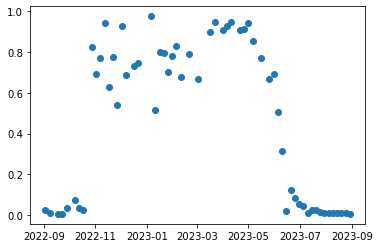

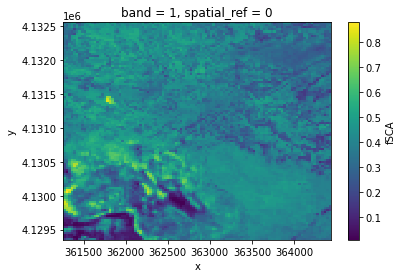

In [75]:
fg,ax = plt.subplots()
ax.scatter(date_array,da['fSCA'].mean(dim=('x','y')).values)

fg,ax = plt.subplots()
filtered_da['fSCA'].mean(dim='time').plot(ax=ax)

In [70]:
duplicates = da['time'].to_series().duplicated()
idx = np.where(duplicates == True)[0][0].astype(int)

print(idx)
print(files_array[idx-1])
print(files_array[idx])
print(files_array[idx+1])

97
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/L30/2022/10TFL/HLS.L30.T10TFL.2022210T185106.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/L30/2022/10TFL/HLS.L30.T10TFL.2022210T185129.v2.0
/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/L30/2022/10TFL/HLS.L30.T10TFL.2022211T184517.v2.0


In [37]:
subb

'/Users/jpflug/Documents/Projects/snowCover_comparisons/Data/HLS/HLS_data/L30/2023/13SCB/HLS.L30.T13SCB.2023232T174405.v2.0'

In [16]:
holder1

<xarray.DataArray (time: 114, y: 104, x: 105)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Dimensions without coordinates: time, y, x

In [12]:
da

<xarray.Dataset>
Dimensions:      (time: 114, y: 104, x: 105)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06 2022-09-12 ... 2023-08-30
    band         int64 1
    spatial_ref  int64 0
  * y            (y) float64 5.306e+06 5.306e+06 ... 5.303e+06 5.303e+06
  * x            (x) float64 4.513e+05 4.514e+05 ... 4.544e+05 4.545e+05
Data variables:
    *empty*

[ -1.  64. 128.]
[ -1.  64. 128.]


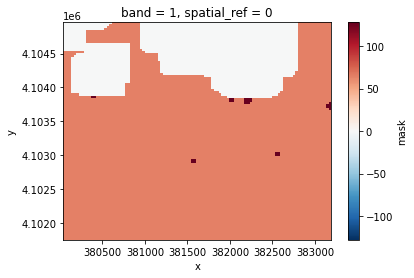

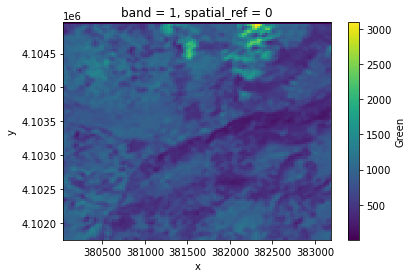

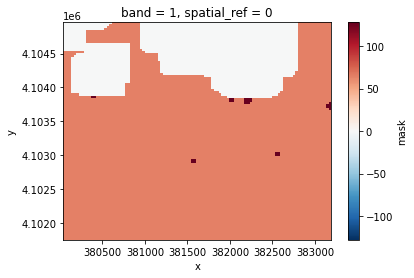

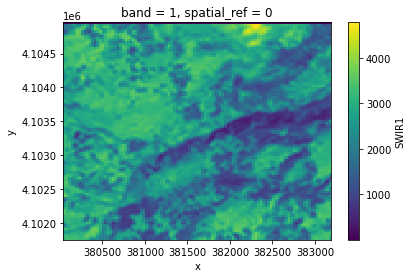

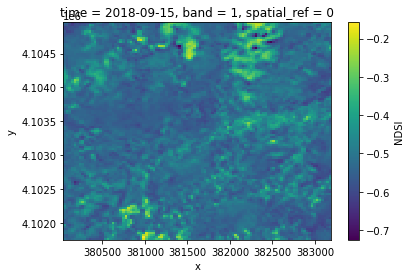

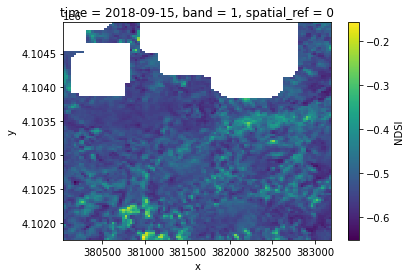

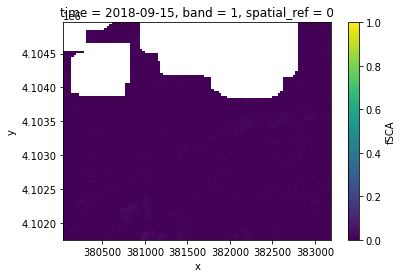

In [139]:
mask = glob.glob(subb+'/*Fmask.tif')[0]
mask = xr.open_dataset(mask).isel(band=0)#.to_dataset(name='mask')
mask = mask.rename({'band_data':'mask'})
condition = np.isin(mask['mask'], good_vals)
condition = xr.Dataset({'condition': (('y', 'x'),condition)})
mask['condition'] = condition['condition']
# 64 and 128 are the only good values
# after doing this step, the resulting values are -1, 64, and 128
mask['mask'] = mask['mask'].where(mask['condition'], -1, 0)

# load green band (identical for S and L data)
green = glob.glob(subb+'/*B03.tif')[0]
#     green = xr.open_rasterio(green)[0,:,:]
green = xr.open_dataset(green).isel(band=0)#[0,:,:]
green = green.sel(x=slice(min_x,max_x),y=slice(max_y,min_y))
mask = mask.sel(x=slice(min_x,max_x),y=slice(max_y,min_y))
mask['green'] = green['band_data']

fg,ax = plt.subplots()
mask['mask'].plot()
print(np.unique(mask['mask'].values))

fg,ax = plt.subplots()
mask['green'].plot()

mask['mask'] = xr.where(mask['green']==-9999,-1,mask['mask'])
fg,ax = plt.subplots()
mask['mask'].plot()
print(np.unique(mask['mask'].values))

# read in the SWIR data
# if sentinel
if version == 'S30':
    swir = glob.glob(subb+'/*B11.tif')[0]
# if landsat
else:
    swir = glob.glob(subb+'/*B06.tif')[0] 
#     swir = xr.open_rasterio(swir)[0,:,:]
swir = xr.open_dataset(swir).isel(band=0)
swir = swir.sel(x=slice(min_x,max_x),y=slice(max_y,min_y))
fg,ax = plt.subplots()
swir['band_data'].plot()

da = xr.Dataset()
da.coords['time'] = date_array
da.coords['y'] = green.y
da.coords['x'] = green.x
holder1 = np.empty((len(date_array),len(green.y),len(green.x)))
holder1[:] = np.nan
holder1 = xr.DataArray(holder1, dims=('time', 'y', 'x'))
da['NDSI'] = holder1 
da['NDSI'][subCount,:,:] = ((green['band_data']-swir['band_data'])/(green['band_data']+swir['band_data'])).astype('float32').values
fg,ax = plt.subplots()
da['NDSI'][subCount,:,:].plot(ax=ax)

holder2 = np.empty((len(date_array),len(green.y),len(green.x)))
holder2[:] = 0
holder2 = xr.DataArray(holder2, dims=('time', 'y', 'x'))
da['Mask'] = holder2
da['Mask'][subCount,:,:] = mask['mask']
# fg,ax = plt.subplots()
# da['Mask'][subCount,:,:].plot(ax=ax)

da['NDSI'] = da['NDSI'].where(da['Mask'] >= 0,np.nan)
fg,ax = plt.subplots()
da['NDSI'][subCount,:,:].plot(ax=ax)

da['fSCA'] = 0.5*(np.tanh((3*da['NDSI'])-1)+1)
fg,ax = plt.subplots()
da['fSCA'][subCount,:,:].plot(ax=ax,vmin=0,vmax=1)

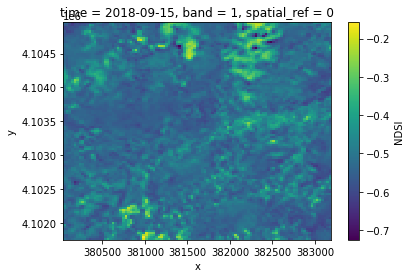

In [132]:
da['NDSI'][subCount,:,:].plot()

In [40]:
for subCount,subb in enumerate(files_array):
#     print(subb)
    mask = glob.glob(subb+'/*Fmask.tif')[0]
    mask = xr.open_dataset(mask).isel(band=0)
    mask = mask.sel(x=slice(min_x,max_x),y=slice(max_y,min_y))
#     mask['band_data'].plot()
    print(subCount,np.unique(mask['band_data'].values))
#     if subCount == 1:
#         break
# mask['band_data'].plot()

0 [64. 96.]
1 [nan]
2 [nan]
3 [194. 198. 200. 202. 204. 206.]
4 [64. 96.]
5 [nan]
6 [194. 200. 202.]
7 [nan]
8 [64. 96.]
9 [nan]
10 [194.]
11 [nan]
12 [64. 96.]
13 [nan]
14 [64. 96.]
15 [nan]
16 [64. 96.]
17 [64. 96.]
18 [nan]
19 [194.]
20 [nan]
21 [ 64.  68.  72.  76. 128. 130. 132. 134. 136. 138. 140. 142. 160. 192.
 194. 196. 198.]
22 [nan]
23 [64. 96.]
24 [nan]
25 [64. 96.]
26 [nan]
27 [64. 96.]
28 [nan]
29 [ 66. 130. 194.]
30 [nan]
31 [nan]
32 [ 66.  74. 130. 194. 200. 202.  nan]
33 [nan]
34 [ 66.  68.  70.  72.  74.  76.  80.  84. 130. 132. 134. 136. 138. 140.
 142. 144. 148. 194. 196. 198. 200. 202. 204. 206. 208. 212.  nan]
35 [192. 194. 196. 198. 200. 202. 204. 206. 208. 212.]
36 [nan]
37 [nan]
38 [ 66.  68.  70.  72.  76.  80.  84. 130. 132. 134. 136. 140. 144. 148.
 194. 196. 198. 200. 202. 204. 206. 208. 212.  nan]
39 [nan]
40 [194.]
41 [nan]
42 [ 66.  68.  70.  72.  76.  80.  84. 130. 132. 134. 136. 140. 144. 148.
 192. 194. 196. 198. 200. 202. 204. 206. 208. 212. 224. 240

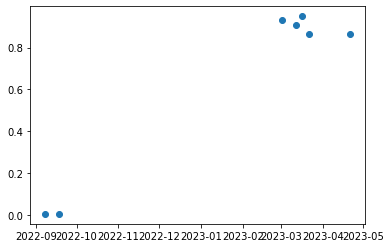

In [65]:
# da['fSCA'].mean(dim='time').plot()
plt.scatter(date_array,da['fSCA'].mean(dim=('x','y')).values)

# da['fSCA'].mean(dim=('x','y')).values

In [24]:
tester = da['fSCA'][0,:,:].values
masker = mask['band_data'].values
tester[masker == 64]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 109 but corresponding boolean dimension is 3660

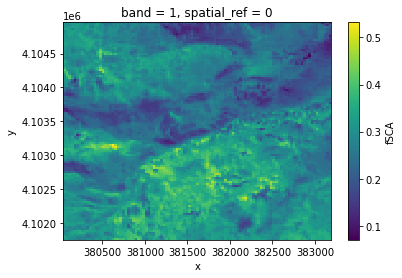

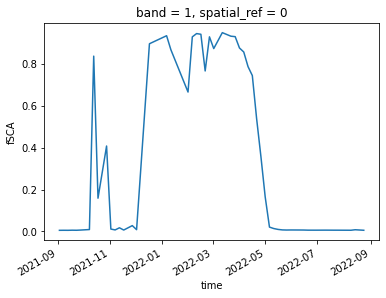

In [59]:
fg,ax = plt.subplots()
filtered_da['fSCA'].mean(dim='time').plot(ax=ax)
fg,ax = plt.subplots()
filtered_da['fSCA'].mean(dim=('x','y')).plot(ax=ax)

In [53]:
crs_string = '+proj=utm +zone=10 +ellps=WGS84 +units=m +no_defs=True'
da['NDSI'].isel(time=2).rio.write_crs(crs_string).rio.to_raster('/Users/jpflug/Documents/TEMP/testNDSI.tif')

# da['NDSI'].isel(time=2).plot()

In [32]:
crs_string = '+proj=utm +zone=10 +ellps=WGS84 +units=m +no_defs=True'
mask['mask'].rio.write_crs(crs_string).rio.to_raster('/Users/jpflug/Documents/TEMP/testMask.tif')
# mask['mask'].rio.write_crs(4326).rio.to_raster('/Users/jpflug/Documents/TEMP/testMask.tif')

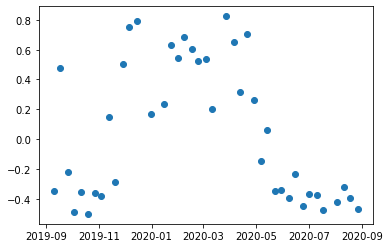

In [398]:
plt.scatter(filtered_da['time'].values,filtered_da['NDSI'].mean(dim=('x','y')).values)

In [28]:
mask

<xarray.Dataset>
Dimensions:    (y: 3660, x: 3660)
Coordinates:
  * y          (y) float64 4.3e+06 4.3e+06 4.3e+06 ... 4.19e+06 4.19e+06
  * x          (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.097e+05
    band       int64 1
Data variables:
    mask       (y, x) int16 128 128 128 64 64 128 128 ... 68 68 68 68 68 68 68
    condition  (y, x) bool True True True True True ... True True True True True